In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pycbc
import pycbc.waveform as wf
from pycbc.detector import Detector
import lalsimulation as lalsim
import lal
from collections import defaultdict
import emcee
import time
import corner

In [24]:
class PSD:
    def __init__(self, psd_filename, prepend_points = [], append_points = []):
        self.f_vals, self.psd_vals = np.loadtxt(psd_filename, unpack = True)
        self.prepend_points = prepend_points
        self.append_points = append_points

        for point in self.prepend_points:
            self.f_vals = np.concatenate([np.array([point[0]]), self.f_vals])
            self.psd_vals = np.concatenate([np.array([point[1]]), self.psd_vals])

        for point in self.append_points:
            self.f_vals = np.concatenate([self.f_vals, np.array([point[0]])])
            self.psd_vals = np.concatenate([self.psd_vals, np.array([point[1]])])

        self.psd = interp1d(self.f_vals, self.psd_vals)

In [25]:
ligo_H1_psd = '/home/mukesh/Academics/EW3/data/GW170814/H1_PSD_GW170814.txt'
ligo_L1_psd = '/home/mukesh/Academics/EW3/data/GW170814/L1_PSD_GW170814.txt'
V1_psd = '/home/mukesh/Academics/EW3/data/GW170814/V1_PSD_GW170814.txt'

H1_psd_int = PSD(ligo_H1_psd)
L1_psd_int = PSD(ligo_L1_psd)
V1_psd_int = PSD(V1_psd)

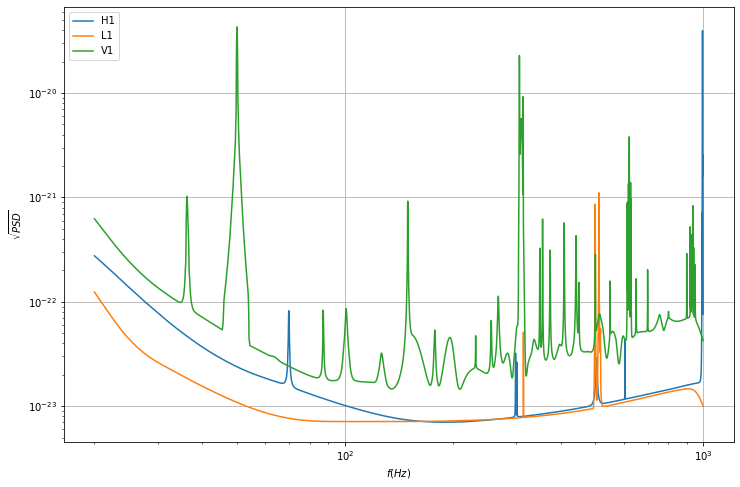

In [26]:
freq = np.linspace(20, 1000, 10000)
plt.figure(figsize=(12,8))
plt.loglog(freq, np.sqrt(H1_psd_int.psd(freq)), label='H1')
plt.loglog(freq, np.sqrt(L1_psd_int.psd(freq)), label='L1')
plt.loglog(freq, np.sqrt(V1_psd_int.psd(freq)), label='V1')
plt.xlabel('$f(Hz)$')
plt.ylabel('$\sqrt{PSD}$')
plt.legend(loc='best')
plt.grid()

In [27]:
def spher_harms_plus_cross_factors(inclination, l, m):
    
    Y_lm = lal.SpinWeightedSphericalHarmonic(inclination, 0, -2, l, m)
    Y_lm_star = np.conj(lal.SpinWeightedSphericalHarmonic(inclination, 0, -2, l, -m))
    
    if (l % 2):
        minus1l = -1
    else:
        minus1l = 1
        
    C_lm =  ( Y_lm + minus1l * Y_lm_star)
    D_lm = -1j * ( Y_lm - minus1l * Y_lm_star)
    
    return C_lm, D_lm

In [28]:
def waveform_lm_mode(fmin, fmax, df, mode, m1, m2, inclination, distance, approx):
    
    mode_array_dict = {
        "22": [[2, 2], [2, -2]],
        "32": [[3, 2], [3, -2]],
        "21": [[2, 1], [2, -1]],
        "44": [[4, 4], [4, -4]],
        "33": [[3, 3], [3, -3]],
        "43": [[4, 3], [4, -3]]
    }
    
    hp, hc = wf.get_fd_waveform(approximant= approx,
                                mass1 = m1, 
                                mass2 = m2, 
                                inclination= inclination,
                                distance = distance,
                                f_lower = fmin,
                                f_final = fmax,
                                delta_f = df,
                                mode_array = mode_array_dict[mode]
                                #coa_phase = coa_phase)
                               )
    # remove the angular dependence through dividing by spherical harmonics
    # so that we have to evaluate instrinsic part only once
    l = int(mode[0])
    m = int(mode[1])
    C_lm, D_lm = spher_harms_plus_cross_factors(inclination, l, m)
    freq = hp.sample_frequencies.data
    hp = hp.data/C_lm
    hc = hc.data/(D_lm)
    h_intrinsic = hp
    return freq, h_intrinsic, hc

In [29]:
fr, hp22, hc22 = waveform_lm_mode(f_min, f_max, df, "22", mle["m1"], mle["m2"], mle["theta_jn"], mle["distance"], mle["approx"])
fr, hp33, hc33 = waveform_lm_mode(f_min, f_max, df, "33", mle["m1"], mle["m2"], mle["theta_jn"], mle["distance"], mle["approx"])
fr, hp44, hc44 = waveform_lm_mode(f_min, f_max, df, "44", mle["m1"], mle["m2"], mle["theta_jn"], mle["distance"], mle["approx"])

(20, 2661.5886523801128)

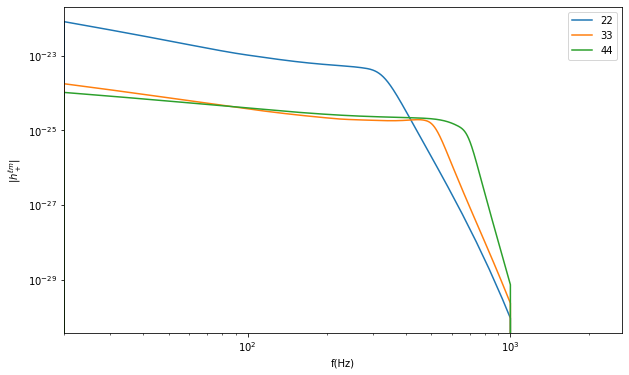

In [43]:
plt.figure(figsize=(10,6))
plt.loglog(fr, abs(hp22), label="22")
plt.loglog(fr, abs(hp33), label="33")
plt.loglog(fr, abs(hp44), label="44")
plt.legend(loc='best')
plt.xlabel("f(Hz)")
plt.ylabel("$|h_+^{\ell m}|$")
plt.xlim(20,)

In [427]:
hp22[7000], hc22[7000]

((-1.4540348511542226e-28-1.855288543437645e-28j),
 (-1.4540203681091174e-28-1.855271805490494e-28j))

In [428]:
hp33[2300], hc33[2300]

((1.9930708002652852e-25-2.447957613156882e-26j),
 (1.9930469138539178e-25-2.4478281394106928e-26j))

In [429]:
hp44[2300], hc44[2300]

((-1.5515750855867743e-25-2.0260537970739098e-25j),
 (-1.5515505873446964e-25-2.0260298111911527e-25j))

In [430]:
plt.loglog(fr, abs(hc22 - hp22))
plt.xlim(20,)

(20, 2661.5886523801128)

(20, 2661.5886523801128)

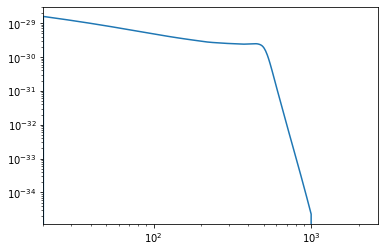

In [431]:
plt.loglog(fr, abs(hc33-hp33))
plt.xlim(20,)

### Signal estimated as template evaluated at MLEs:

In [30]:
# ML estimates for GW170814
mle = dict()
mle["ra"] = 47.75*np.pi/180
mle["dec"] = -np.pi/4
mle["psi"] = 0.0
mle["phi0"] = 0.0
mle["m1"] = 30.6
mle["m2"] = 25.2
mle["theta_jn"] = np.pi/4
mle["coa_phase"] = np.pi/4
mle["distance"] = 600.
mle["approx"] = "IMRPhenomXPHM"
mle["geocent_time"] = 1186741861.0
modes = [ "22"]#, "33", "44"]

In [45]:
h_intrinsic = {}
signal = {}
f_min = 20.
f_max = 1000.
df = 0.1
detectors = ["H1", "L1", "V1"]
for det in detectors:
    signal[det] = 0.0
    Det = Detector(det)
    dt =  Det.time_delay_from_earth_center(mle["ra"], mle["dec"], mle["geocent_time"])
    t_det = mle["geocent_time"] - dt 
    fp, fc = Det.antenna_pattern(mle["ra"], mle["dec"], mle["psi"], mle["geocent_time"])
    print("fplus = %f, fcross = %f for and time delay at the detector %s = %f "%(fp, fc, det, dt))
    for mode in modes:
        h_intrinsic[mode] = 0.0
        f, h_intrinsic[mode], _ = waveform_lm_mode(f_min, f_max, df, mode, mle["m1"], mle["m2"], mle["theta_jn"], mle["distance"], mle["approx"])
        l = int(mode[0])
        m = int(mode[1])
        
        lower_index = f >= f_min
        f = f[lower_index]
        h_intrinsic[mode] = h_intrinsic[mode][lower_index]
    
        upper_index = f <= f_max
        f = f[upper_index]
        h_intrinsic[mode] = h_intrinsic[mode][upper_index]
        
        C_lm, D_lm = spher_harms_plus_cross_factors(mle["theta_jn"], l, m)
        phase_shift = (np.cos(2*np.pi*f*t_det + m*mle["phi0"]) + 1j*np.sin(2*np.pi*f*t_det + m*mle["phi0"]))
        signal[det] += (fp*C_lm + fc*D_lm)*h_intrinsic[mode]*phase_shift

fplus = -0.272092, fcross = 0.431132 for and time delay at the detector H1 = 0.003695 
fplus = 0.421714, fcross = -0.300904 for and time delay at the detector L1 = -0.004739 
fplus = 0.441343, fcross = -0.153241 for and time delay at the detector V1 = 0.009089 


In [46]:
plt.figure(figsize=(10,6))
plt.loglog(f, abs(signal["H1"]), label="H1")
plt.loglog(f, abs(signal["L1"]), label="L1")
plt.loglog(f, abs(signal["V1"]), label="V1")
plt.legend(loc='best')
plt.xlabel("f(Hz)")
plt.ylabel("$|h_+^{\ell m}|$")
plt.ylim(1e-24, 2e-23)
plt.xlim(20,)

(20, 1216.0417906586579)

In [47]:
H1_psd = H1_psd_int.psd(f)
L1_psd = L1_psd_int.psd(f)
V1_psd = V1_psd_int.psd(f)

In [48]:
integrand = {}
integrand["H1"] = abs(signal["H1"])**2/H1_psd
integrand["L1"] = abs(signal["L1"])**2/L1_psd
integrand["V1"] = abs(signal["V1"])**2/V1_psd

In [49]:
snr_H1 = np.sqrt(4*np.sum(integrand["H1"])*df)
snr_L1 = np.sqrt(4*np.sum(integrand["L1"])*df)
snr_V1 = np.sqrt(4*np.sum(integrand["V1"])*df)
snr_H1, snr_L1, snr_V1, np.sqrt(snr_H1**2 + snr_L1**2 + snr_V1**2)

(6.820253597811511, 10.49219989054307, 2.790938645028838, 12.82152316231922)

In [50]:
def matched_filter(f_array, signal, model, det):
    
    df = f_array[1]-f_array[0]
    psd = eval('%s_psd'%(det))
    integrand = signal*np.conjugate(model)/psd
    z = np.trapz(integrand, f)
    
    return z

In [51]:
def int_lm(f_array, signal, intrinsic_model, phi0, t_det, mode, det):
    
    df = f_array[1]-f_array[0]
    psd = eval('%s_psd'%(det))
    m = int(mode[1])
    phase_shift = (np.cos(2*np.pi*f*t_det - m*phi0) - 1j*np.sin(2*np.pi*f*t_det - m*phi0))
    numerator = signal*np.conjugate(intrinsic_model*phase_shift)
    integrand = numerator/psd
    
    return np.trapz(integrand, f)

In [52]:
f_plus = {}
f_cross = {}
for det in detectors:
    
    Det = Detector(det)
    dt = Det.time_delay_from_earth_center(mle["ra"], mle["dec"], mle["geocent_time"])
    t_det = mle["geocent_time"] + dt
    z_det = matched_filter(f, signal[det], signal[det], det)

    G_factor = 0.0
    K_factor = 0.0
    for mode in modes:
        
        l = int(mode[0])
        m = int(mode[1])
        I_lm = int_lm(f, signal[det], h_intrinsic[mode], mle["phi0"], t_det, mode, det)
        E_lm, F_lm = spher_harms_plus_cross_factors(mle["theta_jn"], l, m)
        G_factor += I_lm*np.conj(E_lm)
        K_factor += I_lm*np.conj(F_lm)

    f_plus[det] = (np.real(z_det)*np.imag(K_factor) - np.imag(z_det)*np.real(K_factor))/(np.real(G_factor)*np.imag(K_factor) - np.imag(G_factor)*np.real(K_factor))
    f_cross[det] = (np.imag(z_det)*np.real(G_factor) - np.real(z_det)*np.imag(G_factor))/(np.real(G_factor)*np.imag(K_factor) - np.imag(G_factor)*np.real(K_factor))

In [54]:
#f_plus, f_cross

### Evaluating Bayestar likelihood on a grid in $\alpha-\delta$

In [59]:
ra = np.linspace(0, 2*np.pi, 100)
dec = np.arcsin(np.linspace(-1, 1, 100))
ras1, decs1 = np.meshgrid(ra, dec)
ra_flatten = ras1.flatten()
dec_flatten = decs1.flatten()

log_likelihood_full = []
for ras, decs in zip(ra_flatten, dec_flatten):
    parameters = [mle["theta_jn"], mle["distance"], ras, decs, mle["psi"], mle["geocent_time"], mle["phi0"]]
    log_likelihood_full.append(log_bayestarhm_like(parameters))
    
log_likefull_data = np.reshape(log_likelihood_full, ras1.shape)
likefull_data = np.exp(log_likefull_data)/np.sum(np.exp(log_likefull_data))
likefull_data = likefull_data/np.amax(likefull_data)

In [74]:
import matplotlib.colors as colors
plt.figure(figsize=(12, 8))
plt.contourf(ra, dec, np.log(likefull_data)) #, norm=colors.LogNorm()
plt.plot(mle["ra"], mle["dec"], "+")
plt.xlabel(r"$\alpha$[rad]")
plt.ylabel("$\delta$[rad]")
plt.colorbar(label="Log-Likelihood")
#plt.savefig("/home/mukesh/Academics/Bayestar/plots/likelihood_evaluation_ra_dec_grid_22.png")
#plt.show()

### Bilby Likelihood on a grid:

In [122]:
#!/usr/bin/env python
"""
Tutorial to demonstrate running parameter estimation on a full 15 parameter
space for an injected cbc signal. This is the standard injection analysis script
one can modify for the study of injected CBC events.
"""
import numpy as np
import bilby

# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
duration = 4.
sampling_frequency = 2048.

# Specify the output directory and the name of the simulation.
outdir = 'outdir'
label = 'full_15_parameters'
#bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(88170235)

# We are going to inject a binary black hole waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# spins of both black holes (a, tilt, phi), etc.
injection_parameters = dict(
    mass_1=mle["m1"], mass_2=mle["m2"], a_1=0.0, a_2=0.0, tilt_1=0.0, tilt_2=0.0,
    phi_12=0.0, phi_jl=0.0, luminosity_distance=mle["distance"], theta_jn=mle["theta_jn"], psi=mle["psi"],
    phase=0.0, geocent_time=mle["geocent_time"], ra=mle["ra"], dec=mle["dec"])

# Fixed arguments passed into the source model
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=50., minimum_frequency=20.)

# Create the waveform_generator using a LAL BinaryBlackHole source function
# the generator will convert all the parameters
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_zero_noise(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 3)

ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)


# For this analysis, we implement the standard BBH priors defined, except for
# the definition of the time prior, which is defined as uniform about the
# injected value.
# Furthermore, we decide to sample in chirp mass and mass ratio, due to the
# preferred shape for the associated posterior distributions.
priors = bilby.gw.prior.BBHPriorDict()
priors.pop('mass_1')
priors.pop('mass_2')

priors['chirp_mass'] = bilby.prior.Uniform(
    name='chirp_mass', latex_label='$M$', minimum=10.0, maximum=100.0,
    unit='$M_{\\odot}$')

priors['mass_ratio'] = bilby.prior.Uniform(
    name='mass_ratio', latex_label='$q$', minimum=0.5, maximum=1.0)

priors['geocent_time'] = bilby.core.prior.Uniform(
    minimum=injection_parameters['geocent_time'] - 0.1,
    maximum=injection_parameters['geocent_time'] + 0.1,
    name='geocent_time', latex_label='$t_c$', unit='$s$')

# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveoform generator, as well the priors.
# The explicit time, distance, and phase marginalizations are turned on to
# improve convergence, and the parameters are recovered by the conversion
# function.
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator, priors=priors,
    distance_marginalization=False, phase_marginalization=True, time_marginalization=False)

12:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
12:31 bilby INFO    : Injected signal in H1:
12:31 bilby INFO    :   optimal SNR = 20.79
12:31 bilby INFO    :   matched filter SNR = 20.79+0.00j
12:31 bilby INFO    :   mass_1 = 30.6
12:31 bilby INFO    :   mass_2 = 25.2
12:31 bilby INFO    :   a_1 = 0.0
12:31 bilby INFO    :   a_2 = 0.0
12:31 bilby INFO    :   tilt_1 = 0.0
12:31 bilby INFO    :   tilt_2 = 0.0
12:31 bilby INFO    :   phi_12 = 0.0
12:31 bilby INFO    :   phi_jl = 0.0
12:31 bilby INFO    :   luminosity_distance = 600.0
12:31 bilby INFO    :   theta_jn = 0.7853981633974483
12:31 bilby INFO    :   psi = 0.0
12:31 bilby INFO    :   phase = 0.0
12:31 bilby INFO    :   geocent_time = 1186741861.0
12:31 bilby INFO    :   ra = 0.8333947178272924
12:31 bilby INFO    :   dec = -0.78539

In [83]:
injections = injection_parameters
logL_ra_dec = []
ra = np.linspace(0, 2*np.pi, 100)
sin_dec = np.linspace(-1, 1, 100)
dec = np.arcsin(sin_dec)
ra_grid, dec_grid = np.meshgrid(ra, dec)
X = ra_grid.flatten()
Y = dec_grid.flatten()
for ra1, dec1 in zip(X, Y):
    
    injections["ra"] = ra1
    injections["dec"] = dec1
    
    likelihood.parameters = injections
    log_likelihood_ratio = likelihood.log_likelihood_ratio()
    
    logL_ra_dec.append(log_likelihood_ratio)

In [86]:
logL_ra_dec_grid = np.reshape(logL_ra_dec, ra_grid.shape)
likefull_bilby = np.exp(logL_ra_dec_grid)/np.sum(np.exp(logL_ra_dec_grid))
print(np.sum(np.exp(logL_ra_dec_grid)))
likefull_bilby = likefull_bilby/np.amax(likefull_bilby)

7.263335862704785e+191


In [87]:
plt.figure(figsize=(12, 8))
plt.contourf(ra, dec, np.log(likefull_bilby))
plt.plot(mle["ra"], mle["dec"], "+", markersize=30, c='r')
plt.xlabel(r"$\alpha$[rad]")
plt.ylabel("$\delta$[rad]")
plt.colorbar(label="Likelihood")

/home/mukesh/anaconda3/envs/pycbc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [88]:
fig, ax = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)

ax[0].contourf(ra, dec, np.log(likefull_bilby))
ax[0].plot(mle["ra"], mle["dec"], "+", markersize=30, c='r')
ax[0].set_xlabel(r"$\alpha$[rad]")
ax[0].set_ylabel("$\delta$[rad]")
ax[0].set_title("Bilby")
#ax[0].set_colorbar(label="Likelihood")

ax[1].contourf(ra, dec, np.log(likefull_data))
ax[1].plot(mle["ra"], mle["dec"], "+", markersize=30, c='r')
ax[1].set_xlabel(r"$\alpha$[rad]")
ax[1].set_title("Bayestar")

#fig.savefig("/home/mukesh/Academics/Bayestar/plots/ExtrinsicPE/Bayestar_Bilby_ra_dec_likelihood_on_grid.png")

/home/mukesh/anaconda3/envs/pycbc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Bayestar')

In [126]:
injections = injection_parameters
iota = np.linspace(0, np.pi, 100)
dL = np.linspace(300, 800, 100)
ra_vec = np.linspace(0, 2*np.pi, 100)
dec_vec = np.linspace(-np.pi/2, np.pi/2, 100)
psi_vec = np.linspace(0, 2*np.pi, 100)
tg_vec = mle["geocent_time"] + np.linspace(-0.1, 0.1, 100)
phi0_vec = np.linspace(0, 2*np.pi, 100)
log_L = []
for psi in psi_vec:
    #injections["geocent_time"] = tg
    #injections["theta_jn"] = incl
    #injections["luminosity_distance"] = dist
    #injections["ra"] = ra1
    #injections["dec"] = dec1
    injections["psi"] = psi
    likelihood.parameters = injections
    log_likelihood_ratio = likelihood.log_likelihood_ratio()
    log_L.append(log_likelihood_ratio)
L = np.exp(log_L)/np.sum(np.exp(log_L))

Text(0, 0.5, '$\\log\\mathcal{L}$')

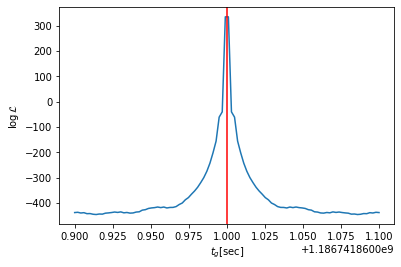

In [104]:
plt.plot(tg_vec, log_L)
plt.axvline(x=mle["geocent_time"], c='r')
plt.xlabel(r"$t_g$[sec]")
plt.ylabel(r"$\log\mathcal{L}$")
#plt.savefig("/home/mukesh/Academics/Bayestar/plots/ExtrinsicPE/Bilby_tg_likelihood_on_grid.png")

Text(0, 0.5, '$\\log\\mathcal{L}$')

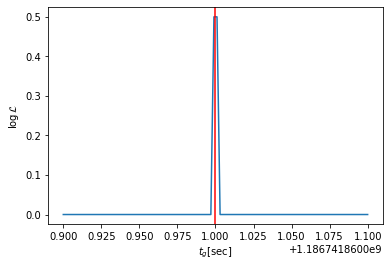

In [105]:
plt.plot(tg_vec, L)
plt.axvline(x=mle["geocent_time"], c='r')
plt.xlabel(r"$t_g$[sec]")
plt.ylabel(r"$\log\mathcal{L}$")

In [112]:
plt.plot(iota, L)
plt.axvline(x=mle["theta_jn"], c='r')
plt.xlabel(r"$\iota$[rad]")

Text(0.5, 0, '$\\iota$[rad]')

Text(0.5, 0, '$\\iota$[rad]')

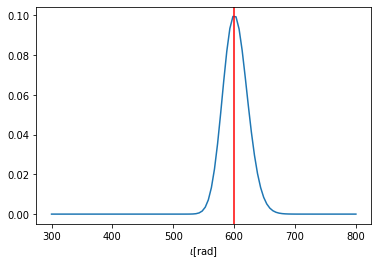

In [116]:
plt.plot(dL, L)
plt.axvline(x=mle["distance"], c='r')
plt.xlabel(r"$\iota$[rad]")

In [121]:
plt.plot(ra_vec, L)
plt.axvline(x=mle["ra"], c='r')
plt.xlabel(r"$\alpha$[rad]")

Text(0.5, 0, '$\\alpha$[rad]')

In [125]:
plt.plot(dec_vec, L)
plt.axvline(x=mle["dec"], c='r')
plt.xlabel(r"$\delta$[rad]")

Text(0.5, 0, '$\\delta$[rad]')

Text(0.5, 0, '$\\psi$[rad]')

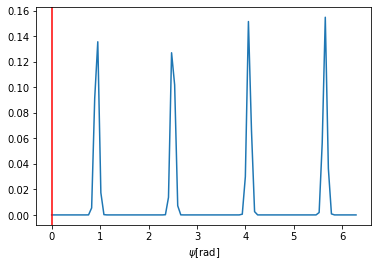

In [128]:
plt.plot(psi_vec, L)
plt.axvline(x=mle["psi"], c='r')
plt.xlabel(r"$\psi$[rad]")

## MCMC sampling:

In [439]:
# ML estimates for GW170814
mle = dict()
mle["ra"] = 47.75*np.pi/180
mle["dec"] = -np.pi/4
mle["psi"] = 0.0
mle["phi0"] = 0.0
mle["m1"] = 30.6
mle["m2"] = 25.2
mle["theta_jn"] = np.pi/4
mle["coa_phase"] = np.pi/4
mle["distance"] = 600.
mle["approx"] = "IMRPhenomXPHM"
mle["geocent_time"] = 1186741861.0

In [504]:
modes = ["22"]#, "33", "44"]
h_intrinsic = {}
signal = {}
f_min = 20.
f_max = 1000.
df = 0.1
detectors = ["H1", "L1", "V1"]
for det in detectors:
    signal[det] = 0.0
    Det = Detector(det)
    dt =  Det.time_delay_from_earth_center(mle["ra"], mle["dec"], mle["geocent_time"])
    t_det = mle["geocent_time"] #- dt
    fp, fc = Det.antenna_pattern(mle["ra"], mle["dec"], mle["psi"], mle["geocent_time"])
    print("fplus = %f, fcross = %f for and time at the detector %s = %f "%(fp, fc, det, mle["geocent_time"] - dt))
    for mode in modes:
        h_intrinsic[mode] = 0.0
        f, h_intrinsic[mode], _ = waveform_lm_mode(f_min, f_max, df, mode, mle["m1"], mle["m2"], mle["theta_jn"], mle["distance"], mle["approx"])
        l = int(mode[0])
        m = int(mode[1])
        
        lower_index = f >= f_min
        f = f[lower_index]
        h_intrinsic[mode] = h_intrinsic[mode][lower_index]
    
        upper_index = f <= f_max
        f = f[upper_index]
        h_intrinsic[mode] = h_intrinsic[mode][upper_index]
        
        C_lm, D_lm = spher_harms_plus_cross_factors(mle["theta_jn"], l, m)
        phase_shift = (np.cos(2*np.pi*f*t_det + m*mle["phi0"]) + 1j*np.sin(2*np.pi*f*t_det + m*mle["phi0"]))
        #phase_shift = np.cos(m*mle["phi0"]) + 1j*np.sin(m*mle["phi0"])
        signal[det] += (fp*C_lm + fc*D_lm)*h_intrinsic[mode]*phase_shift

fplus = -0.272092, fcross = 0.431132 for and time at the detector H1 = 1186741860.996305 
fplus = 0.421714, fcross = -0.300904 for and time at the detector L1 = 1186741861.004740 
fplus = 0.441343, fcross = -0.153241 for and time at the detector V1 = 1186741860.990911 


In [505]:
H1_psd = H1_psd_int.psd(f)
L1_psd = L1_psd_int.psd(f)
V1_psd = V1_psd_int.psd(f)

In [606]:
def bayestarhm_source_model(frequency_array, intrinsic_signal, geocent_time, ra, dec, psi, phi0, inclination, distance, det, kwargs):
    #evaluates only extrinsic part of the waveform
    #Intrinsic part of the signal of every mode should be provided as a dictionary    
    #geocent_time = mle["geocent_time"] + geocent_time 
    #phi0 = mle["phi0"]
    #distance = mle["distance"]
    #inclination = mle["theta_jn"]
    #ra = mle["ra"]
    #dec = mle["dec"]
    #psi = mle["psi"]
    
    Det = Detector(det)
    #dt = Det.time_delay_from_earth_center(ra, dec, geocent_time)
    t_det = geocent_time #- dt  
    fp, fc = Det.antenna_pattern(ra, dec, psi, geocent_time)
    
    signal_model = 0.0
    phase_shift_t_det = np.cos(2*np.pi*frequency_array*t_det) + 1j*np.sin(2*np.pi*frequency_array*t_det)
    for mode in kwargs["modes"]:
        l = int(mode[0])
        m = int(mode[1])
        C_lm, D_lm = spher_harms_plus_cross_factors(inclination, l, m)
        phase_shift = phase_shift_t_det*(np.cos(m*phi0) + 1j*np.sin(m*phi0))
        signal_model += (fp*C_lm + fc*D_lm)*intrinsic_signal[mode]*phase_shift
            
    return signal_model*(mle["distance"]/distance)

In [839]:
def log_bayestarhm_like_emcee(params_vec):
    
    waveform_kwargs = {}
    waveform_kwargs["modes"] = ["22"]#, "33", "44"]
    frequency_array = f
    log_likelihood = 0.0
    #if condition plays the role of prior
    if (mle["geocent_time"]-0.1 <= params_vec[0] and params_vec[0] <= mle["geocent_time"]+0.1)*(0 <= params_vec[1] and params_vec[1] <=2*np.pi)*(-1 <= params_vec[2] and params_vec[2] <=1)*(0 <= params_vec[3] and params_vec[3] <=2*np.pi)*(0 <= params_vec[4] and params_vec[4] <=2*np.pi)*(-1 <= params_vec[5] and params_vec[5] <=1)*(100 <= params_vec[6] and params_vec[6] < 1000) == 1:
        for det in detectors:
            model = bayestarhm_source_model(frequency_array, h_intrinsic, params_vec[0], params_vec[1], np.arcsin(params_vec[2]), 
                                         params_vec[3], params_vec[4], np.arccos(params_vec[5]), params_vec[6],\
                                            det, waveform_kwargs)
            likelihood_integrand = abs(signal[det] - model)**2 /2 #-np.real(signal[det]*np.conj(model)) + abs(model)**2 / 2 #
            psd = eval('%s_psd'%(det))
            log_likelihood += -4*np.trapz(likelihood_integrand/psd, frequency_array) + np.log(params_vec[6])/2
        return log_likelihood
    else:
        return -np.inf

In [840]:
n_walkers = 50
ndim = 7
burnin_steps = 500
steps = 10000
guess_value = np.array([mle["geocent_time"], mle["ra"], np.sin(mle["dec"]), mle["psi"], mle["phi0"], np.cos(mle["theta_jn"]), mle["distance"]])
#, mle["theta_jn"], mle["distance"], mle["ra"], mle["dec"],  mle["geocent_time"], mle["psi"], mle["phi0"]

In [841]:
p0_zero = np.ones([n_walkers,ndim])*guess_value
p0 = p0_zero+np.array([np.random.rand(ndim)*1e-04 for i in range(n_walkers)])

In [842]:
t0 = time.time()
sampler = emcee.EnsembleSampler(n_walkers,ndim,log_bayestarhm_like_emcee)
p1,lnpos1,rs1 = sampler.run_mcmc(p0,burnin_steps)
sampler.reset()
sampler.run_mcmc(p1,steps)
tf = time.time()
print("Time taken in running Emcee sampler with %d walkers and %d steps = %f"%(n_walkers, steps, (tf-t0)))

Time taken in running Emcee sampler with 50 walkers and 10000 steps = 4131.610675


In [843]:
for samples in sampler.chain[:,:,0]:
    plt.plot(samples, c="k", alpha=0.5)
plt.axhline(y=mle["geocent_time"], c="r")
plt.xlabel("Chain")
plt.ylabel("$t_g$[secs]")
#plt.savefig("/home/mukesh/Academics/Bayestar/plots/ExtrinsicPE/emcee_chain_for_geocent_time.png")
plt.show()

In [844]:
for samples in sampler.chain[:,:,5]:
    plt.plot(np.arccos(samples), c="k", alpha=0.5)
plt.axhline(y=mle["theta_jn"], c="r")
#plt.savefig("/home/mukesh/Academics/Bayestar/plots/ExtrinsicPE/emcee_chain_for_geocent_time.png")
plt.show()

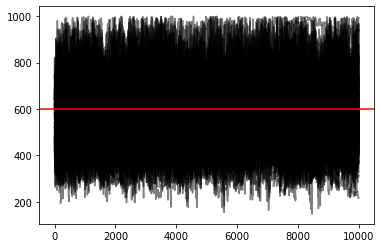

In [845]:
for samples in sampler.chain[:,:,6]:
    plt.plot((samples), c="k", alpha=0.5)
plt.axhline(y=mle["distance"], c="r")
#plt.savefig("/home/mukesh/Academics/Bayestar/plots/ExtrinsicPE/emcee_chain_for_geocent_time.png")
plt.show()

In [767]:
sampler.chain[:,:,0].shape

(14, 10000)

In [769]:
sampler.chain[:,:,0][13]

array([1.18674186e+09, 1.18674186e+09, 1.18674186e+09, ...,
       1.18674186e+09, 1.18674186e+09, 1.18674186e+09])

In [817]:
sampler.lnprobability

array([[83.48592863, 83.48592863, 87.4178722 , ..., 89.01874989,
        89.01874989, 89.01874989],
       [85.47625468, 85.47625468, 85.47625468, ..., 88.17587027,
        88.66197089, 88.66197089],
       [89.12153259, 89.12153259, 89.12153259, ..., 89.24158866,
        89.24158866, 89.24158866],
       ...,
       [89.22015384, 89.22015384, 89.22015384, ..., 88.21698809,
        88.21698809, 88.21698809],
       [87.53167031, 87.4757607 , 87.4757607 , ..., 86.7567175 ,
        86.7567175 , 86.7567175 ],
       [89.21915911, 89.21915911, 89.21915911, ..., 88.94588951,
        88.61698561, 88.26004162]])

In [818]:
sampler.acceptance_fraction

array([0.3369, 0.3499, 0.3238, 0.3179, 0.3405, 0.3204, 0.3367, 0.3266,
       0.2742, 0.3413, 0.3268, 0.334 , 0.2657, 0.3302])

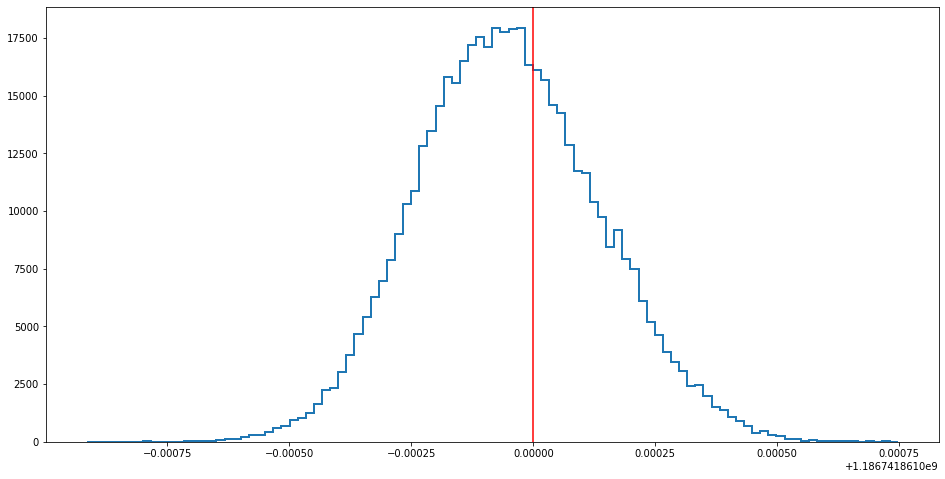

In [846]:
plt.figure(figsize=(16,8))
plt.hist(sampler.flatchain[:,0], bins=100, histtype=u'step', lw=2)
plt.axvline(x=mle["geocent_time"], c='r')
plt.show()

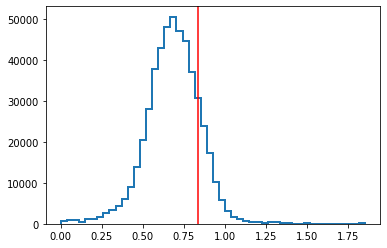

In [847]:
plt.hist(sampler.flatchain[:,1], bins=50, histtype=u'step', lw=2)
plt.axvline(x=mle["ra"], c='r')
plt.show()

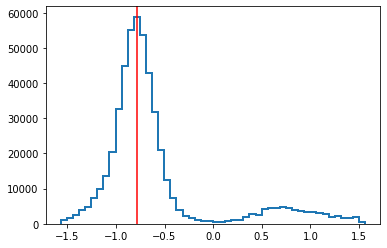

In [848]:
plt.hist(np.arcsin(sampler.flatchain[:,2]), bins=50, histtype=u'step', lw=2)
plt.axvline(x=mle["dec"], c='r')
plt.show()

Text(0, 0.5, '$\\delta$[rad]')

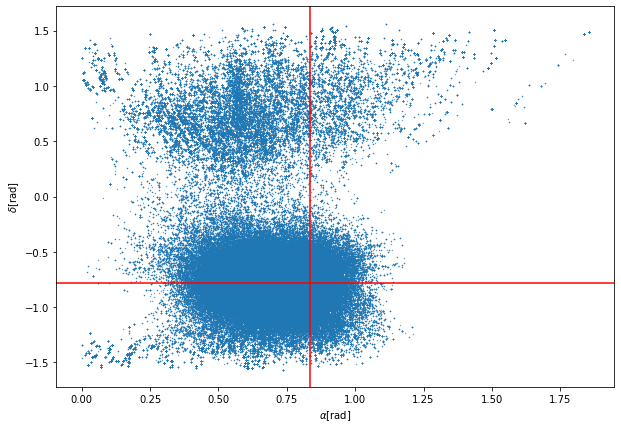

In [849]:
plt.figure(figsize=(10, 7))
plt.scatter(sampler.flatchain[:,1], np.arcsin(sampler.flatchain[:,2]), s=0.1)
plt.axvline(x=mle["ra"], c='r')
plt.axhline(y=mle["dec"], c='r')
plt.xlabel(r"$\alpha$[rad]")
plt.ylabel(r"$\delta$[rad]")

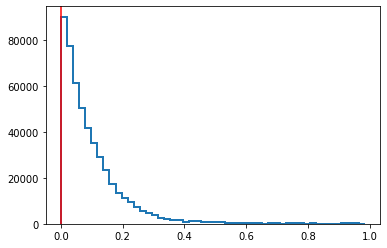

In [850]:
plt.hist(sampler.flatchain[:,3], bins=50, histtype=u'step', lw=2)
plt.axvline(x=mle["psi"], c='r')
plt.show()

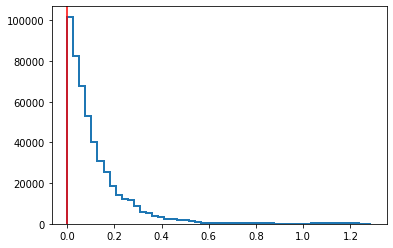

In [851]:
plt.hist(sampler.flatchain[:,4], bins=50, histtype=u'step', lw=2)
plt.axvline(x=mle["phi0"], c='r')
plt.show()

In [799]:
#dataframe = pd.DataFrame(sampler.flatchain)
#dataframe.to_csv("22_emcee_sampling_run_all_extrinsic_params_walkers_%d_steps_%d_burnin_steps_%d.dat"%(n_walkers, steps, burnin_steps), sep=" ", header=["geocent_time", "ra", "dec", "psi", "phi0", "iota", "distance"], index=False)

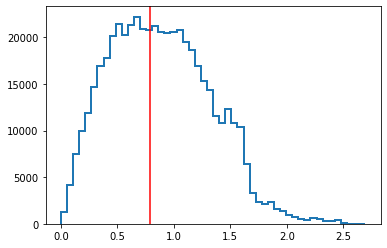

In [852]:
plt.hist(np.arccos(sampler.flatchain[:,5]), bins=50, histtype=u'step', lw=2)
plt.axvline(x=mle["theta_jn"], c='r')
plt.show()

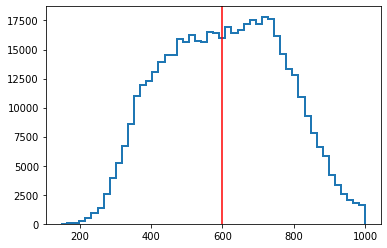

In [853]:
plt.hist(sampler.flatchain[:,6], bins=50, histtype=u'step', lw=2)
plt.axvline(x=mle["distance"], c='r')
plt.show()

In [838]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(14, 18))

ax[0, 0].hist(sampler.flatchain[:,1], bins=50, density=True, histtype=u'step', lw=2)
ax[0, 0].set_ylabel("Probability")
ax[0, 0].set_xlabel(r"$\alpha$[rad]")
ax[0, 0].vlines(x=mle["ra"], ymin=0, ymax=3, colors='r', label="True value")
ax[0, 0].grid()
ax[0, 0].legend(loc="best")

ax[0, 1].hist(np.arcsin(sampler.flatchain[:,2]), bins=50, density=True, histtype=u'step', lw=2)
ax[0, 1].set_ylabel("Probability")
ax[0, 1].set_xlabel(r"$\delta$[rad]")
ax[0, 1].vlines(x=mle["dec"], ymin=0, ymax=2.2, colors='r')
ax[0, 1].grid()

ax[1, 0].hist(np.arccos(sampler.flatchain[:,5]), bins=50, density=True, histtype=u'step', lw=2)
ax[1, 0].set_ylabel("Probability")
ax[1, 0].set_xlabel(r"$\iota$[rad]")
ax[1, 0].vlines(x=mle["theta_jn"], ymin=0, ymax=0.9, colors='r')
ax[1, 0].grid()

ax[1, 1].hist(sampler.flatchain[:,0], bins=50, density=True, histtype=u'step', lw=2)
ax[1, 1].set_ylabel("Probability")
ax[1, 1].set_xlabel(r"$t_g$[secs]")
ax[1, 1].vlines(x=mle["geocent_time"], ymin=0, ymax=2500, colors='r')
ax[1, 1].grid()

ax[2, 0].hist(sampler.flatchain[:,3], bins=50, density=True, histtype=u'step', lw=2)
ax[2, 0].set_ylabel("Probability")
ax[2, 0].set_xlabel(r"$\psi$[rad]")
ax[2, 0].grid()
ax[2, 0].vlines(x=mle["psi"], ymin=0, ymax=10, colors='r')

ax[2, 1].hist(sampler.flatchain[:,4], bins=50, density=True, histtype=u'step', lw=2)
ax[2, 1].set_ylabel("Probability")
ax[2, 1].set_xlabel(r"$\varphi_0$[rad]")
ax[2, 1].grid()
ax[2, 1].vlines(x=mle["phi0"], ymin=0, ymax=8, colors='r')

ax[3, 0].hist(sampler.flatchain[:,6], bins=50, density=True, histtype=u'step', lw=2)
ax[3, 0].set_ylabel("Probability")
ax[3, 0].set_xlabel(r"$d_L$[Mpc]")
ax[3, 0].grid()
ax[3, 0].vlines(x=mle["distance"], ymin=0, ymax=0.0025, colors='r')

fig.savefig("/home/mukesh/Academics/Bayestar/plots/ExtrinsicPE/22_emcee_all_extrinsic_params_with_non_uniformative_dL_prior_walkers_50_steps_10000.png")

In [597]:
data = pd.read_csv("/home/mukesh/Academics/Bayestar/scripts/22_emcee_sampling_run_all_extrinsic_params_walkers_14_steps_10000_burnin_steps_500.dat", sep=" ")

In [605]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(14, 18))

ax[0, 0].hist(data["ra"], bins=50, density=True, histtype=u'step', lw=2)
ax[0, 0].set_ylabel("Probability")
ax[0, 0].set_xlabel(r"$\alpha$[rad]")
ax[0, 0].vlines(x=mle["ra"], ymin=0, ymax=3, colors='r', label="True value")
ax[0, 0].grid()
ax[0, 0].legend(loc="best")

ax[0, 1].hist(data["dec"], bins=50, density=True, histtype=u'step', lw=2)
ax[0, 1].set_ylabel("Probability")
ax[0, 1].set_xlabel(r"$\delta$[rad]")
ax[0, 1].vlines(x=mle["dec"], ymin=0, ymax=2.5, colors='r')
ax[0, 1].grid()

ax[1, 0].hist(data["iota"], bins=50, density=True, histtype=u'step', lw=2)
ax[1, 0].set_ylabel("Probability")
ax[1, 0].set_xlabel(r"$\iota$[rad]")
ax[1, 0].vlines(x=mle["theta_jn"], ymin=0, ymax=2, colors='r')
ax[1, 0].grid()

ax[1, 1].hist(data["geocent_time"], bins=50, density=True, histtype=u'step', lw=2)
ax[1, 1].set_ylabel("Probability")
ax[1, 1].set_xlabel(r"$t_g$[secs]")
ax[1, 1].vlines(x=mle["geocent_time"], ymin=0, ymax=3000, colors='r')
ax[1, 1].grid()

ax[2, 0].hist(data["psi"], bins=50, density=True, histtype=u'step', lw=2)
ax[2, 0].set_ylabel("Probability")
ax[2, 0].set_xlabel(r"$\psi$[rad]")
ax[2, 0].grid()
ax[2, 0].vlines(x=mle["psi"], ymin=0, ymax=10, colors='r')

ax[2, 1].hist(data["phi0"], bins=50, density=True, histtype=u'step', lw=2)
ax[2, 1].set_ylabel("Probability")
ax[2, 1].set_xlabel(r"$\varphi_0$[rad]")
ax[2, 1].grid()
ax[2, 1].vlines(x=mle["phi0"], ymin=0, ymax=10, colors='r')

ax[3, 0].hist(data["distance"], bins=50, density=True, histtype=u'step', lw=2)
ax[3, 0].set_ylabel("Probability")
ax[3, 0].set_xlabel(r"$d_L$[Mpc]")
ax[3, 0].grid()
ax[3, 0].vlines(x=mle["distance"], ymin=0, ymax=0.004, colors='r')

In [150]:
data = pd.read_csv("/home/mukesh/Academics/Bayestar/data/GW170814/emcee_sampling/22_emcee_sampling_run_iota_dL_walkers_50_steps_100000_burnin_steps_1000.dat", sep=" ")

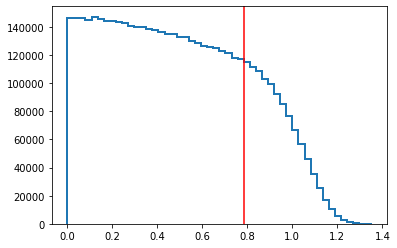

In [152]:
plt.hist(data["theta_jn"], bins=50, histtype=u'step', lw=2)
plt.axvline(x=mle["theta_jn"], c='r')
plt.show()

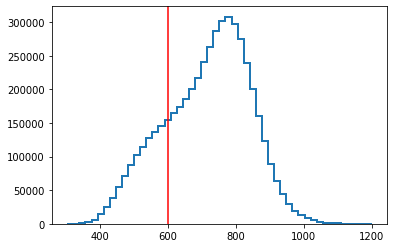

In [153]:
plt.hist(data["luminosity_distance"], bins=50, histtype=u'step', lw=2)
plt.axvline(x=mle["distance"], c='r')
plt.show()

In [163]:
plt.figure(figsize=(10, 7))
plt.scatter(data["theta_jn"], data["luminosity_distance"], s=1)
plt.axhline(y=600, c='r')
plt.axvline(x=np.pi/4, c='r')

In [586]:
data = pd.read_csv("/home/mukesh/Academics/Bayestar/scripts/data/22_emcee_sampling_run_geocent_time_ra_dec_psi_phi0_iota_params_walkers_12_steps_10000_burnin_steps_500.dat", sep=" ")

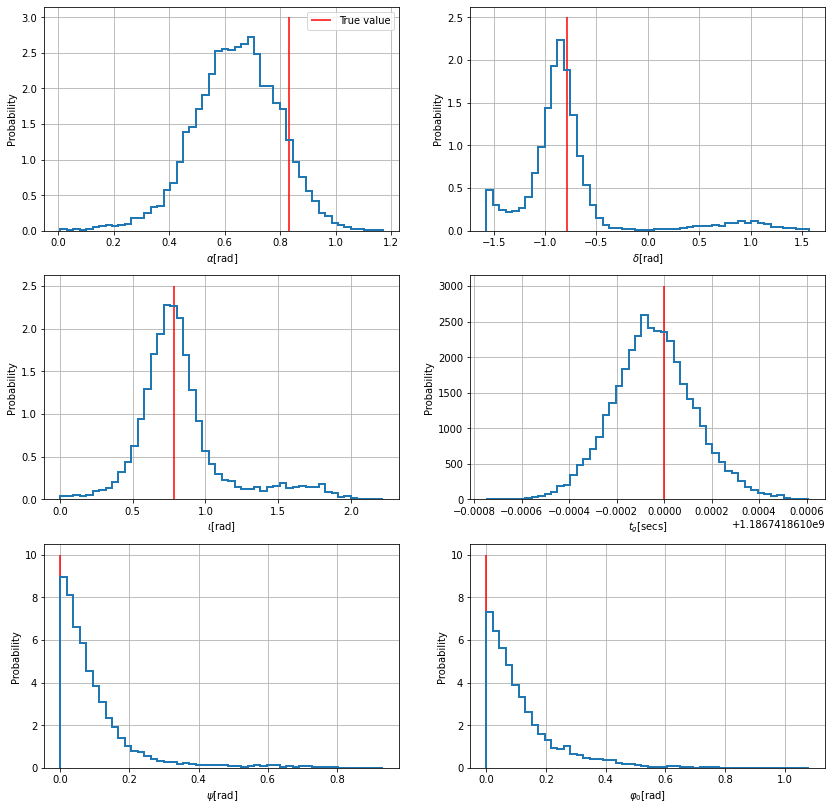

In [587]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))

ax[0, 0].hist(data["ra"], bins=50, density=True, histtype=u'step', lw=2)
ax[0, 0].set_ylabel("Probability")
ax[0, 0].set_xlabel(r"$\alpha$[rad]")
ax[0, 0].vlines(x=mle["ra"], ymin=0, ymax=3, colors='r', label="True value")
ax[0, 0].grid()
ax[0, 0].legend(loc="best")

ax[0, 1].hist(data["dec"], bins=50, density=True, histtype=u'step', lw=2)
ax[0, 1].set_ylabel("Probability")
ax[0, 1].set_xlabel(r"$\delta$[rad]")
ax[0, 1].vlines(x=mle["dec"], ymin=0, ymax=2.5, colors='r')
ax[0, 1].grid()

ax[1, 0].hist(data["iota"], bins=50, density=True, histtype=u'step', lw=2)
ax[1, 0].set_ylabel("Probability")
ax[1, 0].set_xlabel(r"$\iota$[rad]")
ax[1, 0].vlines(x=mle["theta_jn"], ymin=0, ymax=2.5, colors='r')
ax[1, 0].grid()

ax[1, 1].hist(data["geocent_time"], bins=50, density=True, histtype=u'step', lw=2)
ax[1, 1].set_ylabel("Probability")
ax[1, 1].set_xlabel(r"$t_g$[secs]")
ax[1, 1].vlines(x=mle["geocent_time"], ymin=0, ymax=3000, colors='r')
ax[1, 1].grid()

ax[2, 0].hist(data["psi"], bins=50, density=True, histtype=u'step', lw=2)
ax[2, 0].set_ylabel("Probability")
ax[2, 0].set_xlabel(r"$\psi$[rad]")
ax[2, 0].grid()
ax[2, 0].vlines(x=mle["psi"], ymin=0, ymax=10, colors='r')

ax[2, 1].hist(data["phi0"], bins=50, density=True, histtype=u'step', lw=2)
ax[2, 1].set_ylabel("Probability")
ax[2, 1].set_xlabel(r"$\varphi_0$[rad]")
ax[2, 1].grid()
ax[2, 1].vlines(x=mle["phi0"], ymin=0, ymax=10, colors='r')

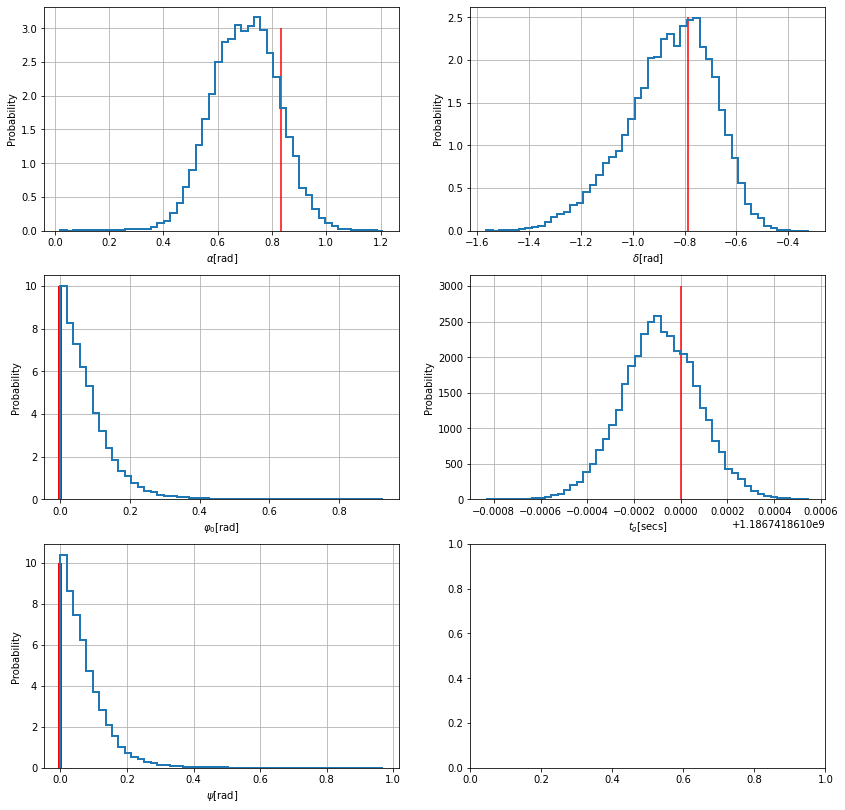

In [583]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))

ax[0, 0].hist(data["ra"], bins=50, density=True, histtype=u'step', lw=2)
ax[0, 0].set_ylabel("Probability")
ax[0, 0].set_xlabel(r"$\alpha$[rad]")
ax[0, 0].vlines(x=mle["ra"], ymin=0, ymax=3, colors='r')
ax[0, 0].grid()

ax[0, 1].hist(data["dec"], bins=50, density=True, histtype=u'step', lw=2)
ax[0, 1].set_ylabel("Probability")
ax[0, 1].set_xlabel(r"$\delta$[rad]")
ax[0, 1].vlines(x=mle["dec"], ymin=0, ymax=2.5, colors='r')
ax[0, 1].grid()

ax[1, 0].hist(data["phi0"], bins=50, density=True, histtype=u'step', lw=2)
ax[1, 0].set_ylabel("Probability")
ax[1, 0].set_xlabel(r"$\varphi_0$[rad]")
ax[1, 0].grid()
ax[1, 0].vlines(x=mle["phi0"], ymin=0, ymax=10, lw=4, colors='r')

ax[1, 1].hist(data["geocent_time"], bins=50, density=True, histtype=u'step', lw=2)
ax[1, 1].set_ylabel("Probability")
ax[1, 1].set_xlabel(r"$t_g$[secs]")
ax[1, 1].vlines(x=mle["geocent_time"], ymin=0, ymax=3000, colors='r')
ax[1, 1].grid()

ax[2, 0].hist(data["psi"], bins=50, density=True, histtype=u'step', lw=2)
ax[2, 0].set_ylabel("Probability")
ax[2, 0].set_xlabel(r"$\psi$[rad]")
ax[2, 0].grid()
ax[2, 0].vlines(x=mle["psi"], ymin=0, ymax=10, lw=4, colors='r')

In [857]:
data = pd.read_csv("/home/mukesh/Academics/Bayestar/scripts/data/22_emcee_sampling_run_all_extrinsic_params_walkers_50_steps_100000_burnin_steps_1000.dat", sep=" ")

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(14, 18))

ax[0, 0].hist(data["ra"], bins=50, density=True, histtype=u'step', lw=2)
ax[0, 0].set_ylabel("Probability")
ax[0, 0].set_xlabel(r"$\alpha$[rad]")
ax[0, 0].vlines(x=mle["ra"], ymin=0, ymax=3, colors='r', label="True value")
ax[0, 0].grid()
ax[0, 0].legend(loc="best")

ax[0, 1].hist(np.arcsin(data["dec"]), bins=50, density=True, histtype=u'step', lw=2)
ax[0, 1].set_ylabel("Probability")
ax[0, 1].set_xlabel(r"$\delta$[rad]")
ax[0, 1].vlines(x=mle["dec"], ymin=0, ymax=2.5, colors='r')
ax[0, 1].grid()

ax[1, 0].hist(np.arccos(data["iota"]), bins=50, density=True, histtype=u'step', lw=2)
ax[1, 0].set_ylabel("Probability")
ax[1, 0].set_xlabel(r"$\iota$[rad]")
ax[1, 0].vlines(x=mle["theta_jn"], ymin=0, ymax=2, colors='r')
ax[1, 0].grid()

ax[1, 1].hist(data["geocent_time"], bins=50, density=True, histtype=u'step', lw=2)
ax[1, 1].set_ylabel("Probability")
ax[1, 1].set_xlabel(r"$t_g$[secs]")
ax[1, 1].vlines(x=mle["geocent_time"], ymin=0, ymax=3000, colors='r')
ax[1, 1].grid()

ax[2, 0].hist(data["psi"], bins=50, density=True, histtype=u'step', lw=2)
ax[2, 0].set_ylabel("Probability")
ax[2, 0].set_xlabel(r"$\psi$[rad]")
ax[2, 0].grid()
ax[2, 0].vlines(x=mle["psi"], ymin=0, ymax=10, colors='r')

ax[2, 1].hist(data["phi0"], bins=50, density=True, histtype=u'step', lw=2)
ax[2, 1].set_ylabel("Probability")
ax[2, 1].set_xlabel(r"$\varphi_0$[rad]")
ax[2, 1].grid()
ax[2, 1].vlines(x=mle["phi0"], ymin=0, ymax=10, colors='r')

ax[3, 0].hist(data["distance"], bins=50, density=True, histtype=u'step', lw=2)
ax[3, 0].set_ylabel("Probability")
ax[3, 0].set_xlabel(r"$d_L$[Mpc]")
ax[3, 0].grid()
ax[3, 0].vlines(x=mle["distance"], ymin=0, ymax=0.004, colors='r')